# Solution

```{note}
To activate Python interaction, click {fa}`rocket` --> {guilabel}`Live Code` on the top right corner of this screen. The packages and functions provided on the previous page are loaded into this notebook, but hidden from view so that you can focus on understanding the solution.

The download page feature has been disabled to force you to read and understand the solution, rather than copy and paste it. 😊
```

## Case Study Introduction

## Deterministic Parameters

Relevant values are specified in the equations below, except for the crest elevation of the dike, which is 8 m. As it is measured relative to the dike toe, the reference datum, the crest elevation is equivalent to the crest height:
$$
Z_{\mathrm{crest}}=h_{\mathrm{crest}}=8.0 \; \mathrm{m}
$$

## Random Variables

For the case described above, four variables are considered random. There distributions are specified here, along with the location and scale parameters, using the format $\sim \mathrm{DIST}(loc,\,scale)$:

- Significant wave height [m], $Hs\sim\mathrm{Gumbel}(1, 0.2)$
- Wind speed [m/s], $u\sim\mathrm{Exp}(20, 1)$
- Water elevation [m], $Z_w\sim\mathrm{N}(4, 0.4)$
- Bottom elevation [m], $Z_b\sim\mathrm{N}(1, 0.1)$

Note that the location and scale parameters are _not_ the mean and standard deviation, but will make it much easier to specify these distributions using the appropriate `rv_continuous` sub-class from the `scipy.stats` package.

## Governing Equations

The mathematical formulation of the governing equations are defined here, which should be incorporated in Python functions.

**Wind set-up**

$$
S = C \cdot \frac{u^2}{g \cdot d} \cdot F
$$

Where:
- $S$ [m] is the _vertical_ increase in water level due to wind-induced setup at the toe of the dike, relative to the "still" water level
- $C$ [$-$] is a constant ($4\cdot 10^{-6}$)
- $u$ [m/s] is a representative wind speed
- $g$ is the gravitational constant
- $d$ [m] is the average water depth over the length of the inlet; we will use the value measured at the _entrance_ of the inlet (i.e., $d_{\mathrm{offshore}}$, see below)
- $F$ [m] is the distance over which the wind is acting

**Run-up level**

$$
Ru_{2\%} = 8 \cdot H_s \cdot \tan(\alpha)
$$

Where:
- $Ru_{2\%}$ [m] is the _vertical_ distance over which waves run up a slope after breaking, relative to the "still" water level
- $H_s$ [m] is the significant wave height
- $\alpha$ is the slope (can specify in degrees or radians as long as you use $\tan$ appropriately)

**Water depth, offshore**

Here "offshore" refers to the conditions that are relatively far from the shore; for this case, it can be taken as the inlet entrance.

$$
d_{\mathrm{offshore}}  = Z_w - Z_b
$$

Where:
- $Z$ denotes elevation relative to a datum such that the toe of the dike is $Z$=0 m (in other words: 0 m is not necessarily sea level!)
- $Z_w$ and $Z_b$ are elevations of the water surface and bottom level of the inlet. They are considered random variables in order to take into account the tide and variability of bottom level, respectively.

As the bottom of the inlet has a variable elevation, this is an average depth.

**Water elevation/depth at the dike**

Because the setup is evaluated using offshore conditions, and we assume that the wave system does not change as it propagates through the inlet (ignore wind waves, damping, shoaling, breaking, etc.) the water depth at the dike can be approximated as a simple summation of the tidal level, 

$$
Z_d = Z_w + Ru_{2\%} + S
$$ 

Substituting each part from above gives the complete equation:

$$
Z_d
= Z_w
+ 8 H_s \tan(\alpha)
+ C \frac{u^2}{g (Z_w - Z_b)}F
$$

For our later tasks, note in particular the relationship of the four random variables:
- linearly proportional to $H_s$ and $u^2$
- non-linear relationship with $Z_w$ and $Z_b$

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as st

def wind_set_up(u, d, F=3000, C=4.0e-6):
    """
    Calculate wind set-up at the toe of the dike, relative to still water level.

    Parameters
    ----------
    u : float
        [m/s] Representative wind speed
    d : float
        [m] Average depth over fetch length. Take "offshore" depth as proxy.
    F : float
        [m] Fetch length, default is 3000 m (3 km)
    C : float, optional
        [-] Empirical constant, between 3.5e-6 and 4.0e-6, default is 4.0e-6
    
    Returns
    -------
    S : float
        [m] Wind set-up at toe of the dike
    """

    g = 9.81
    S = C*(u**2)/(g*d)*F  
    return S

def run_up_level(Hs, alpha):
    import numpy as np
    """
    Calculate run-up level at the toe of the dike, relative to still water level.

    Parameters
    ----------
    Hs : float
        [m] Significant wave height
    alpha : float
        [degrees] Angle of the slope of the toe of dike
    
    Returns
    -------
    Ru2 : float
        [m] Run-up level, exceeded by 2% of the waves
    """
    # Since numpy works with radians, we need to convert the angle to radians
    alpha_radians = np.radians(alpha)

    Ru2 = 8*Hs*np.tan(alpha_radians)
    return Ru2

def water_at_dike(Hs, u, Zw, Zb, alpha=20, F=10000, C2 = 4.0e-6):
    """
    Calculate the effective water elevation at the dike.

    Parameters
    ----------
    Hs : float
        [m] Significant wave height
    alpha : float
        [degrees] Angle of the slope of the toe of dike
    u : float
        [m/s] Representative wind speed
    d : float
        [m] Average depth over fetch length
    F : float
        [m] Fetch length
    Zw : float
        [m] Offshore water elevation (tidal level)
    Zb : float
        [m] Offshore bed level (or bottom level)
    
    Intermediate Parameter
    ----------------------
    d_offshore : float
        [m] Depth of water at the offshore location, Zw - Zb

    Returns
    -------
    Zd : float
        [m] Elevation of water level at the dike.
              - Equivalent to water depth, as datum is toe of dike
              - Sum of tidal level, run-up, wind set-up
    """

    d_offshore = Zw - Zb

    S = wind_set_up(u, d_offshore, F, C2)

    Ru2 = run_up_level(Hs, alpha)
    
    Zd = Zw + Ru2 + S

    return Zd

## Part 1: Functional response of the system (deterministic)

1. Identify the main physical processes that are at play in this problem, and get familiar with the equations available to describe them.
2. Write an equation (on paper) to define failure of the dike. You can use the code provided to check your answer.
3. Now that you have an equation, identify which parameters have a positive or negative effect on the performance of the dike (hint: check the partial derivatives!)
4. Which environmental variable governs the dike design in this situation? Wave height or wind setup?

```{admonition} Solution, Part 1

The relevant processes and equations are defined above. It is important to recognize that even though the waves are periodic, the concept of 2% wave runup height allows us to use a single value to evaluate whether or not the dike height is sufficient. As $Z_d$ increases, the dike becomes less safe; failure is assumed to happen when $Z_d>Z_{\mathrm{crest}}$.

From the equation of $Z_d$ it is relatively straightforward to see whether each variable has a positive or negative impact

Although not illustrated here thoroughly, you can use the Python function below to change the values of the input variables and see which has the largest change on the output. A few observations are described here:
- Water surface elevation has the largest effect when making a 10% change in the absolute value
- Significant wave height has the biggest infinitesimal impact on the water level height
- The sensitivity of wind speed is _higher_ when the initial value of wind speed is higher (e.g., 30 m/s instead of 20 m/s)

The takeaways are:
- Because the units are different, it can be difficult to compare all variables in a consistent way
- The "initial" values that you consider make an impact on the conclusion
- Variability of the variables should also be taken into account, because it gives an idea for hwhat the likely range of change is for each one
```

In [ ]:
def check_sensitivity(function, values, index, change, absolute_value=False):
    """
    Check sensitivity of a function to a change in one of its arguments.

    Parameters
    ----------
    function : function
        The function for which the sensitivity is to be checked
    values : list
        List of arguments to the function
    index : int
        Index of the argument to be changed
    change : float
        The amount by which the argument is to be changed
    absolute_value : bool, optional
        If True, the change is added to the argument.
        If False, the argument is multiplied by the change.
        Default is False.

    Returns
    -------
    None
    """

    start_value = (values[0],
                   values[1],
                   values[2],
                   values[3])

    if absolute_value:
        changes = [0, 0, 0, 0]
        changes[index] = change
        moved_value = (values[0] + changes[0],
                       values[1] + changes[1],
                       values[2] + changes[2],
                       values[3] + changes[3])
        print(f'Changing argument {index} by adding {change:.2f}')
    else:
        changes = [1., 1., 1., 1.]
        changes[index] = change
        moved_value = (values[0]*changes[0],
                       values[1]*changes[1],
                       values[2]*changes[2],
                       values[3]*changes[3])
        print(f'Changing argument {index} by {change:.1e} times')
        

    one = function(*start_value)
    two = function(*moved_value)

    print(f'--------------------------------------------------------')
    print(f'The starting value is {one:.3f}')
    print(f'The moved value is {two:.3f}')
    print(f'The calculated value has changed by {two - one:.2e}\n')


In [ ]:
for i in range(4):
    check_sensitivity(water_at_dike, [1, 20, 4, 1], i, .001)

Changing argument 0 by 1.0e-03 times
--------------------------------------------------------
The starting value is 7.455
The moved value is 4.547
The calculated value has changed by -2.91e+00

Changing argument 1 by 1.0e-03 times
--------------------------------------------------------
The starting value is 7.455
The moved value is 6.912
The calculated value has changed by -5.44e-01

Changing argument 2 by 1.0e-03 times
--------------------------------------------------------
The starting value is 7.455
The moved value is 1.278
The calculated value has changed by -6.18e+00

Changing argument 3 by 1.0e-03 times
--------------------------------------------------------
The starting value is 7.455
The moved value is 7.320
The calculated value has changed by -1.36e-01



## Part 2: Uncertainty in the system

_Here is where you apply the [continuous parametric distributions](https://mude.citg.tudelft.nl/2023/book/probability/Reminder_intro.html) from MUDE!_

1. Define the distributions of each random variable using `scipy.stats` and get familiar with their characteristics
2. Which random variables have the most significant variability?
3. Identify how each random variable influences the equations defined in the deterministic part above.
4. Which random variable do you think will govern the dike design in this situation?

```{admonition} Solution, Part 2
First the distributions are defined as instances of the class `rv_continuous` from `scipy.stats`, then a few calculations are made and put into a table to see what the variability of each random variable is.
```

In [11]:
Hs = st.gumbel_r(loc=1, scale=0.2)
u = st.expon(loc=20, scale=1)
Zw = st.norm(loc=4, scale=0.4)
Zb = st.norm(loc=1, scale=0.1)

all_dist_vars = ['Hs', 'u', 'Z_w', 'Z_bed']
all_dist = [Hs, u, Z_w, Z_bed]
table = [['Variable', 'Dist', 'Mean', 'Std Dev', 'c.o.v.', 
          '5% value', '95% value', '99% value']]
for variable, dist in zip(all_dist_vars, all_dist):
    table.append([variable,
                  dist.dist.name,
                  '{:0.3f}'.format(dist.mean()),
                  '{:0.3f}'.format(dist.std()),
                  '{:0.3f}'.format(dist.std()/dist.mean()),
                  '{:0.3f}'.format(dist.ppf(0.05)),
                  '{:0.3f}'.format(dist.ppf(0.95)),
                  '{:0.3f}'.format(dist.ppf(0.99))])

for row in table:
    print(''.join([f'{item: <10}' for item in row]))


Variable  Dist      Mean      Std Dev   c.o.v.    5% value  95% value 99% value 
Hs        gumbel_r  1.115     0.257     0.230     0.781     1.594     1.920     
u         expon     21.000    1.000     0.048     20.051    22.996    24.605    
Z_w       norm      4.000     0.400     0.100     3.342     4.658     4.931     
Z_bed     norm      1.000     0.100     0.100     0.836     1.164     1.233     


```{admonition} Solution, Part 2 (continued)

First of all, note that for the non-Gaussian distributions the location and scale parameters are **not** the same thing as the mean and standard deviation! However, in this case, the numerical values are not that different.

It is clear that the wind speed has the largest quantitative range, but it is important to recognize that this does _not_ imply that it has the biggest impact on the dike design. The concept of _variability_ can be difficult to quantify consistently, as the relative range and units of a random variable make it difficult to compare (for example, wind speed and wave height are in m/s and m, respectively). In addition, the _variability_ of a random variable should be somehow related to the absolute value of common realizations. This is why coefficient of variation (c.o.v., $\sigma/\mu$) is a useful metric. In this case it is clear that the c.o.v. of wave height is much higher than wind speed. But does that mean it will have the biggest impact on the dike design? Not necessarily!

Recall from Part 1 that the random variables all combine to produce an effective water level at the dike. We can't tell from the distributions of the random variables themselves if the wind speed or the wave height would increase the effective water level observed at the dike more _given the probability distributions associated with them._ To understand that we need to somehow combine the likelihood of high values of these "load" variables along with the mechanical response of the dike (i.e., plug the values into the function from Part 1!). We will do this in Part 3.
```

## Part 3: Assessing the system

1. Using the Python functions provided, identify conditions where the dike (in its "current" form) is unsafe (using deterministic values only). Describe these critical conditions using a few values and figures.
2. Compute the probability that dike is unsafe. Does it meet the safety criteria?

```{admonition} Solution, Part 3

We already have a function to quantify the demand, or "load," on the system: $Z_d$. The survivial or "resistance" of the dike is a simple check of whether the calculated load exceeds the capacity (the crest height).

The "Monte Carlo Simulation" part comes in because we would like to do this for many realizations of the random variables, to estimate the failure probaiblity as the fraction of realizations where the dike has "failed." Since the random variables are all statistically independent, we can sample from each distribution separately, then plug the values into our function to obtain an empirical distribution of $Z_d$. Then the failure probability is simply $P[Z_d>Z_{\mathrm{crest}}]$.

This is illustrated in the code below.
```

In [47]:
n = 1000

Hs_samples = Hs.rvs(size = n)
u_samples = u.rvs(size = n)
Zw_samples = Zw.rvs(size = n)
Zb_samples = Zb.rvs(size = n)

d_offshore = Zw_samples - Zb_samples

Zd_samples = water_at_dike(Hs_samples,
                           u_samples,
                           Zw_samples,
                           Zb_samples)
dike_height = 8
count = np.sum(Zd_samples > dike_height)
print(f'There are {count} samples greater than the dike height of {dike_height:0.2f} m ')
print(f'({count/n*100:0.2f}% of the samples).')

There are 373 samples greater than the dike height of 8.00 m 
(37.30% of the samples).


```{admonition} Solution, Part 3 (continued)

As we can see, the calculated probability far exceeds the allowable probability of 1%, so we must do something to improve this dike!
```

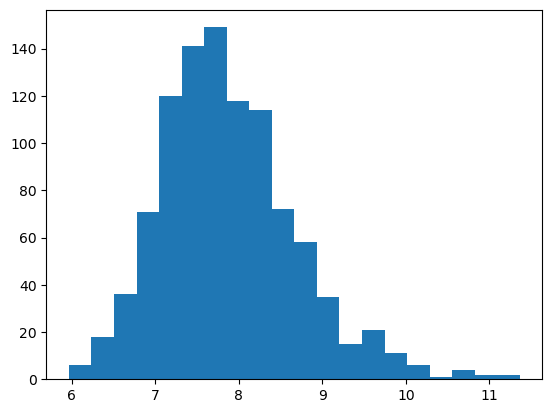

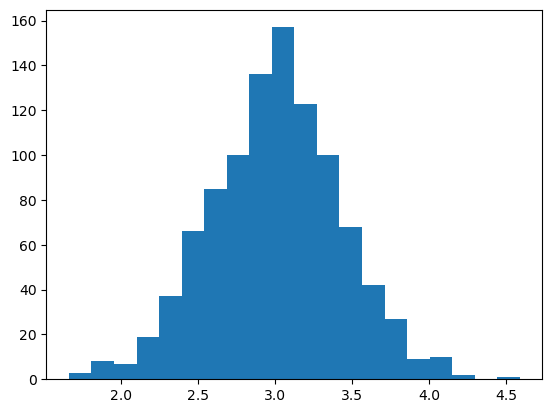

In [46]:
plt.hist(d_dike_samples, bins=20)
plt.show()

d_offshore = Zw_samples - Zb_samples
plt.hist(d_offshore, bins=20)
plt.show()

## Part 4: Designing a better system

1. Reconsider the deterministic and random variables and identify if and how each of them could be changed to improve the system. You should be able to think of explicit examples for what you can do in "real life" and explain the quantitative effect on each variable. For the random variables, you should explicitly consider whether you can influence one of three things: the mean, standard deviation or type of distribution. You should also explain whether a measure is practical. For example: _making the inlet more shallow by placing dredge spoils in it would reduce the mean value of water depth and would impact the runup height by ... ... ...; however, this is probably very expensive and not a very practical idea!_
2. Make a recommendation for how you can improve the system to meet the safety criteria. Explain the quantitative effect on the system (as described above) and provide quantitative confirmation that in these conditions the dike is safe.


```{admonition} Solution, Part 4

There are many approaches to this, so you are encouraged to use the code yourself to explore various options. The main approach is to change the deterministic parameters and the location and scale of the random variables to see the quantitative effect on probability. Observations should include:
- you can have achieve big improvements by changing $u$ and $H_s$, however, since these are natural phenomenon, it is difficult to influence them. One practical measure could be installing something in the inlet to reduce wave heights.
- a similar observation can be made about the water and bottom elevations: these variables have an influence on the calculated probability, but are difficult to make changes in practice
- the most "obvious" or "practical" solutions would be to raise the dike or decrease the slope (this only impacts the wave runup). The choice for which one is selected would probably come down to the cost of materials (i.e., how does the cross-sectional area change?).
```